# Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor

import statsmodels.api as sm
import pickle

# Configuration

In [2]:
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(REPO_ROOT, "Datasets_all")

OUT_DIR = Path("models")
OUT_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42
N_SPLITS = 5

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV  = os.path.join(DATA_DIR, "test.csv")

TARGET_COL = "AimoScore"
DROP_FEATURES = ["EstimatedScore"]  # EstimatedScore is excluded from input features as mentioned in slide 16 of lecture 2

# Load data

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

Train shape: (1599, 42)
Test shape : (400, 42)


In [4]:
print(train_df.columns)
train_df.head()

Index(['AimoScore', 'No_1_Angle_Deviation', 'No_2_Angle_Deviation',
       'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation',
       'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation',
       'No_9_Angle_Deviation', 'No_10_Angle_Deviation',
       'No_11_Angle_Deviation', 'No_12_Angle_Deviation',
       'No_13_Angle_Deviation', 'No_1_NASM_Deviation', 'No_2_NASM_Deviation',
       'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_5_NASM_Deviation',
       'No_6_NASM_Deviation', 'No_7_NASM_Deviation', 'No_8_NASM_Deviation',
       'No_9_NASM_Deviation', 'No_10_NASM_Deviation', 'No_11_NASM_Deviation',
       'No_12_NASM_Deviation', 'No_13_NASM_Deviation', 'No_14_NASM_Deviation',
       'No_15_NASM_Deviation', 'No_16_NASM_Deviation', 'No_17_NASM_Deviation',
       'No_18_NASM_Deviation', 'No_19_NASM_Deviation', 'No_20_NASM_Deviation',
       'No_21_NASM_Deviation', 'No_22_NASM_Deviation', 'No_23_NASM_Deviation',
       'No_24_NASM_Deviation', 'No_25

,AimoScore,No_1_Angle_Deviation,No_2_Angle_Deviation,No_3_Angle_Deviation,No_4_Angle_Deviation,No_5_Angle_Deviation,No_6_Angle_Deviation,No_7_Angle_Deviation,No_8_Angle_Deviation,No_9_Angle_Deviation,...,No_19_NASM_Deviation,No_20_NASM_Deviation,No_21_NASM_Deviation,No_22_NASM_Deviation,No_23_NASM_Deviation,No_24_NASM_Deviation,No_25_NASM_Deviation,No_1_Time_Deviation,No_2_Time_Deviation,EstimatedScore
0,0.965848,0.816834,0.250120,0.346724,0.188905,0.163080,0.140124,0.194165,0.521760,0.156385,...,0.670971,0.656624,0.642276,0.552846,0.648972,0.578192,0.308943,0.148733,0.151124,0.009087
1,0.407282,0.279770,0.139168,0.346724,0.303682,0.928264,0.659971,0.918221,0.521760,0.561932,...,0.670971,0.656624,0.788140,0.908656,0.648972,0.578192,0.891918,0.684840,0.711621,0.837877
2,0.810337,0.279770,0.092300,0.392157,0.799617,0.722621,0.753228,0.730273,0.521760,0.156385,...,0.670971,0.656624,0.642276,0.896222,0.648972,0.578192,0.308943,0.148733,0.186514,0.424199
3,0.603826,0.906743,0.494978,0.571019,0.735533,0.706839,0.140124,0.670971,0.521760,0.156385,...,0.670971,0.764228,0.666188,0.552846,0.648972,0.578192,0.552367,0.811573,0.820182,0.550933
4,0.141338,0.672884,0.583931,0.346724,0.861310,0.555715,0.859876,0.469632,0.767097,0.358680,...,0.899570,0.656624,0.642276,0.552846,0.882353,0.816356,0.308943,0.982783,0.982783,0.741750


In [5]:
# USing copy so that we can later make changes/modify without changing the original data
def split_xy(df: pd.DataFrame):
    drop_cols = [TARGET_COL] + [c for c in DROP_FEATURES if c in df.columns]
    X = df.drop(columns=drop_cols).copy()
    y = df[TARGET_COL].astype(float).copy()
    return X, y

X_train_full, y_train_full = split_xy(train_df)
X_test_full, y_test = split_xy(test_df)

# Created to apply feature weight vector of slide 19 in correct order
angle_cols = [f"No_{i}_Angle_Deviation" for i in range(1, 14)]  # 13
nasm_cols  = [f"No_{i}_NASM_Deviation"  for i in range(1, 26)]  # 25
time_cols  = [f"No_{i}_Time_Deviation"  for i in range(1, 3)]   # 2
expected_cols = angle_cols + nasm_cols + time_cols              # 40

missing = [c for c in expected_cols if c not in X_train_full.columns]
extra   = [c for c in X_train_full.columns if c not in expected_cols]
print("Missing expected cols:", missing)
print("Unexpected extra cols:", extra)

X_train_full = X_train_full[expected_cols].copy()
X_test_full  = X_test_full[expected_cols].copy()

print("X_train:", X_train_full.shape, "y_train:", y_train_full.shape)
print("X_test :", X_test_full.shape,  "y_test :", y_test.shape)


Missing expected cols: []
Unexpected extra cols: []
X_train: (1599, 40) y_train: (1599,)
X_test : (400, 40) y_test : (400,)


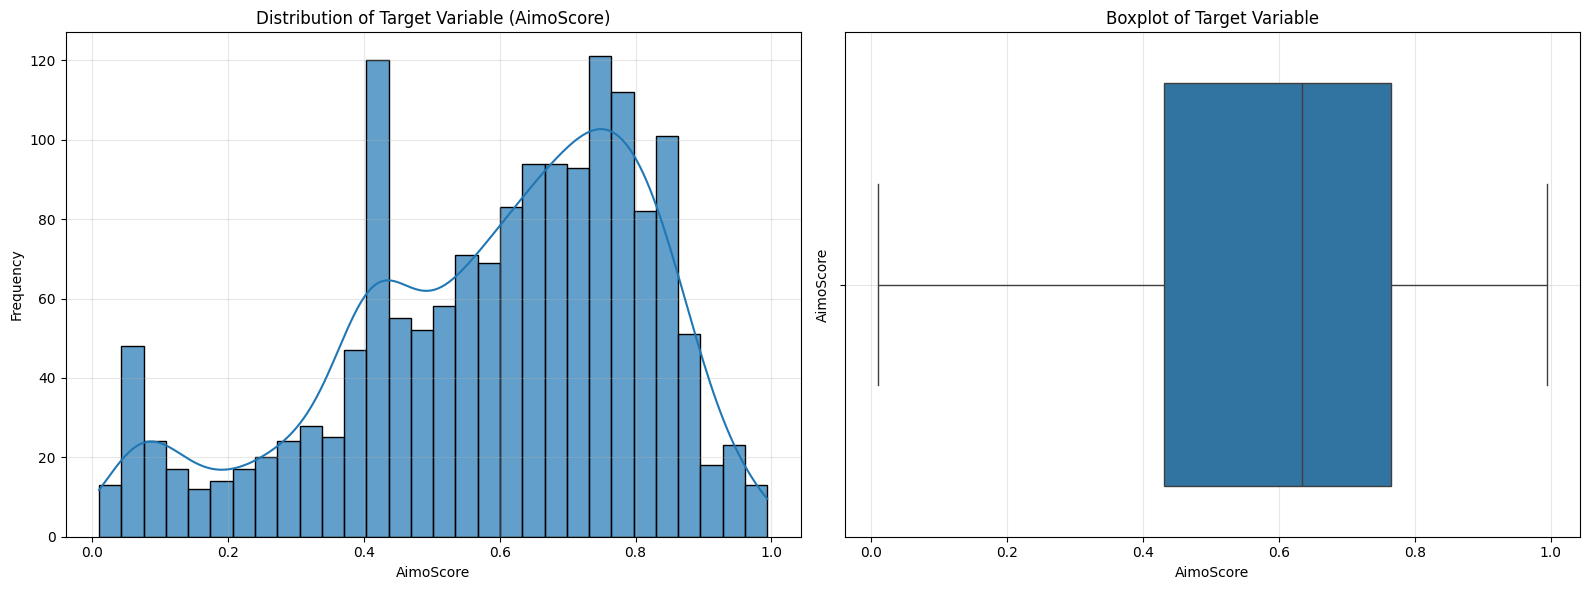

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(y_train_full, bins=30, kde=True, ax=axes[0],  edgecolor='black', alpha=0.7)
axes[0].set_xlabel('AimoScore')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Target Variable (AimoScore)')
axes[0].grid(True, alpha=0.3)

sns.boxplot(x=y_train_full)
axes[1].set_ylabel('AimoScore')
axes[1].set_title('Boxplot of Target Variable')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Duplicate removal

In [7]:
def drop_duplicate_columns(X_train: pd.DataFrame, X_test: pd.DataFrame):
    keep_mask = ~X_train.T.duplicated()
    kept_cols = X_train.columns[keep_mask].tolist()
    return X_train[kept_cols].copy(), X_test[kept_cols].copy(), kept_cols

X_train, X_test, kept_cols = drop_duplicate_columns(X_train_full, X_test_full)
print("After duplicate removal:: X_train:", X_train.shape, "X_test:", X_test.shape)

# Results show that some of the features were duplicate which were
# removed thus creating 35 columns insetead of 40 - Consistent with the slide no. 18

After duplicate removal:: X_train: (1599, 35) X_test: (400, 35)


# Correlation Transformer

In [8]:
# Finds similar features that are highly correlated and remove it
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.99):
        self.threshold = threshold
        self.keep_cols_ = None

    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        # calculates the correlation matrix and takes absolutte values since negative values are also calculated
        corr = Xdf.corr(numeric_only=True).abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] >= self.threshold)]
        self.keep_cols_ = [c for c in Xdf.columns if c not in to_drop]
        return self

    # Applies transformation ad return result as pd dataframe
    def transform(self, X):
        Xdf = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        return Xdf[self.keep_cols_].copy()

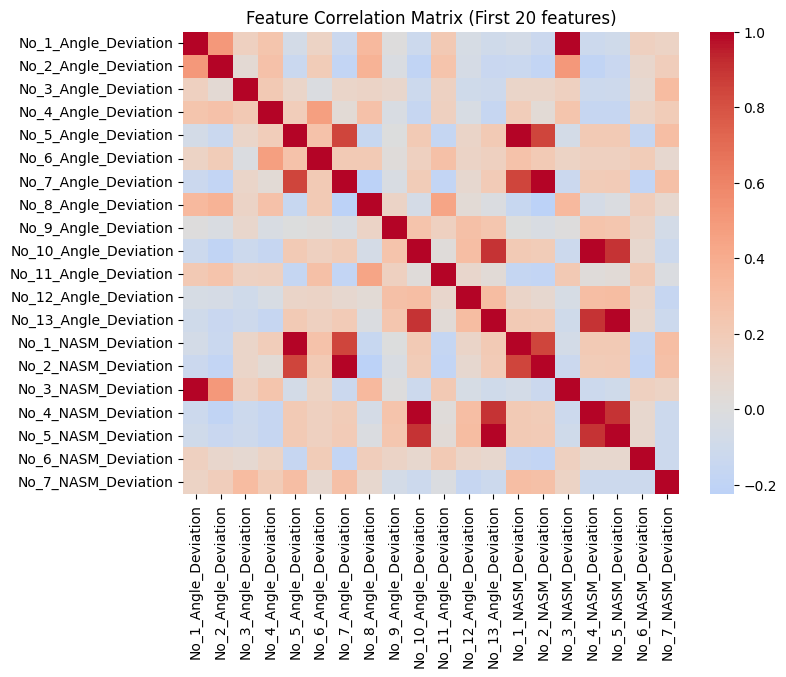

In [9]:
plt.figure(figsize=(8, 6))
corr = X_train_full.iloc[:, :20].corr() 
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (First 20 features)')
plt.show()

# Symmetric Constraint Transformer

In [10]:
# Based on slide 20 of lecture 2 
class SymmetryConstraintTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pairs):
        self.pairs = pairs
        self.feature_mapping_ = None
    
    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        self.feature_mapping_ = {}
        self.new_cols_ = []
        self.drop_cols_ = []
        
        for left, right in self.pairs:
            if left in Xdf.columns and right in Xdf.columns:
                new_name = f"sym_{left}_{right}"
                self.feature_mapping_[new_name] = (left, right)
                self.new_cols_.append(new_name)
                self.drop_cols_.extend([left, right])
        
        # Keep columns not part of any pair
        self.keep_cols_ = [c for c in Xdf.columns if c not in self.drop_cols_]
        
        return self
    
    def transform(self, X):
        Xdf = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        Xout = Xdf[self.keep_cols_].copy() #KEep the remaining columns as it is
        
        # Add symmetric combined features
        for new_col, (left, right) in self.feature_mapping_.items():
            if left in Xdf.columns and right in Xdf.columns:
                Xout[new_col] = (Xdf[left] + Xdf[right]) / 2.0
        
        return Xout


In [11]:
# Define symmetry pairs 
# FMS symmetric pairs [Slide 17 of lab2]
fms_pairs = [
    ("No_4_Angle_Deviation", "No_6_Angle_Deviation"),
    ("No_5_Angle_Deviation", "No_7_Angle_Deviation"),
    ("No_8_Angle_Deviation", "No_11_Angle_Deviation"),
    ("No_9_Angle_Deviation", "No_12_Angle_Deviation"),
    ("No_10_Angle_Deviation", "No_13_Angle_Deviation"),
]

# NASM symmetry pairs [Slide 18 of lab2]
nasm_pairs = [
    ("No_1_NASM_Deviation",  "No_2_NASM_Deviation"),
    ("No_4_NASM_Deviation",  "No_5_NASM_Deviation"),
    ("No_8_NASM_Deviation",  "No_9_NASM_Deviation"),
    ("No_11_NASM_Deviation", "No_12_NASM_Deviation"),
    ("No_13_NASM_Deviation", "No_14_NASM_Deviation"),
    ("No_15_NASM_Deviation", "No_16_NASM_Deviation"),
    ("No_18_NASM_Deviation", "No_19_NASM_Deviation"),
]

sym_pairs = fms_pairs + nasm_pairs  # 12 pairs total

# Weightd linear regression Transformer

In [12]:
# Referred from Slide 19 of lecture 2
class FeatureWeightMultiplier(BaseEstimator, TransformerMixin):
    def __init__(self, full_weight_map):
        self.full_weight_map = full_weight_map
        self.current_weights_sqrt_ = None

    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        cols = Xdf.columns
        
        weights = []
        for c in cols:
            # 1. Check if it's a standard feature name
            if c in self.full_weight_map:
                weights.append(self.full_weight_map[c])
            # 2. Check if it's a symmetric feature
            elif str(c).startswith("sym_"):
                # Extract the original feature name from the new symmetric name
                # (e.g., extracts "No_10_Angle_Deviation")
                parts = c.split("_")
                original_feature_name = f"{parts[1]}_{parts[2]}_{parts[3]}_{parts[4]}"
                # Use the weight of the original feature (left and right have same weight)
                weights.append(self.full_weight_map.get(original_feature_name, 1.0))
            else:
                weights.append(1.0) # Fallback weight
        
        self.current_weights_sqrt_ = np.sqrt(np.array(weights, dtype=float))
        
        # Validation check
        if len(self.current_weights_sqrt_) != Xdf.shape[1]:
            raise ValueError(f"Weight alignment failed. X has {Xdf.shape[1]} cols, weights has {len(self.current_weights_sqrt_)}")
            
        return self

    def transform(self, X):
        Xdf = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        Xw = Xdf.copy()
        Xw.iloc[:, :] = Xw.values * self.current_weights_sqrt_.reshape(1, -1)
        return Xw


In [13]:
#Define weights (13 Angle + 25 NASM + 2 Time)
FMS_WEIGHTS  = [1,1,1,1,1,1,1,2,2,2,2,2,2]  # 13
NASM_WEIGHTS = [1,1,1,2,2] + [1,1,1,1,2,4,4,2,2,2,2,2,1,1,1,2,2,2,2,2]  # 25
TIME_WEIGHTS = [1,1]  # 2

FEATURE_WEIGHTS_40 = FMS_WEIGHTS + NASM_WEIGHTS + TIME_WEIGHTS

weight_map = dict(zip(expected_cols, FEATURE_WEIGHTS_40))
weights_kept = [weight_map[c] for c in kept_cols]

# Outlier removal

In [14]:
def remove_outliers_iqr(X: pd.DataFrame, y: pd.Series, k=1.5):
    q1, q3 = np.percentile(y, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    mask = (y >= lo) & (y <= hi)
    return X.loc[mask].copy(), y.loc[mask].copy()


def remove_cooks_distance(X: pd.DataFrame, y: pd.Series, threshold=None):
    # Standardize for numerical stability
    Xs = (X - X.mean()) / (X.std(ddof=0) + 1e-12)
    Xs = sm.add_constant(Xs.values, has_constant="add")
    model = sm.OLS(y.values, Xs).fit()
    infl = model.get_influence()
    cooks = infl.cooks_distance[0]
    n = len(y)
    if threshold is None:
        threshold = 4 / n
    mask = cooks <= threshold
    return X.loc[mask].copy(), y.loc[mask].copy()


# Define model variants

In [15]:
def make_baseline():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])

def make_corr_filter_variant():
    return Pipeline([
        ("corrfilter", CorrelationFilter(threshold=0.99)),
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])

def make_feature_selection_variant():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("select", SelectFromModel(LassoCV(cv=5, random_state=RANDOM_STATE), threshold=1e-8)),
        ("lr", LinearRegression())
    ])

def make_combined_features_variant():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("ridge", Ridge(alpha=1.0))
    ])

def make_symmetry_variant():
    return Pipeline([
        ("sym", SymmetryConstraintTransformer(sym_pairs)),
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])

def make_weighted_variant():
    return Pipeline([
        ("w", FeatureWeightMultiplier(full_weight_map=weight_map)), 
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])

def make_combine_all():
    return Pipeline([
        ("corrfilter", CorrelationFilter(threshold=0.95)),
        ("sym", SymmetryConstraintTransformer(sym_pairs)),
        ("w", FeatureWeightMultiplier(full_weight_map=weight_map)), 
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=0.5))
    ])

VARIANTS = {
    "baseline": make_baseline(),
    "corr_filter": make_corr_filter_variant(),
    "feature_selection_lasso": make_feature_selection_variant(),
    "combined_poly2_ridge": make_combined_features_variant(),
    "symmetry_constraint": make_symmetry_variant(),
    "weighted_features": make_weighted_variant(),
    "combined_final":make_combine_all(),
}


### Improving models

In [16]:
def make_random_forest_improved():
    return Pipeline([
        ("corrfilter", CorrelationFilter(threshold=0.95)),
        ("model", RandomForestRegressor(
            n_estimators=300,
            max_depth=20,
            min_samples_split=8,
            min_samples_leaf=3,
            max_features='sqrt',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

# Adding it to the variants dictionary defined above
VARIANTS["random_forest"] = make_random_forest_improved()
print(f"\nTotal models to evaluate: {len(VARIANTS)}")


Total models to evaluate: 8


# Evaluation metrics

In [17]:
def compute_metrics(y_true, y_pred):
    # Computes metrics (actual score and model's prediction)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rsquared   = r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0,1] if len(y_true) > 1 else np.nan
    return rmse, mae, rsquared, corr

# Performs 5-fold cross validation technique
def cv_evaluate_pipeline(name, pipe, X, y, cv):
    rmses, maes, r2s, corrs = [], [], [], []
    for tr_idx, va_idx in cv.split(X):
        X_tr, y_tr = X.iloc[tr_idx].copy(), y.iloc[tr_idx].copy()
        X_va, y_va = X.iloc[va_idx].copy(), y.iloc[va_idx].copy()

        pipe.fit(X_tr, y_tr)
        pred = pipe.predict(X_va)
        rmse, mae, r2, corr = compute_metrics(y_va, pred)

        rmses.append(rmse); maes.append(mae); r2s.append(r2); corrs.append(corr)

    return {
        "variant": name,
        "cv_rmse_mean": float(np.mean(rmses)),
        "cv_rmse_std":  float(np.std(rmses)),
        "cv_mae_mean":  float(np.mean(maes)),
        "cv_r2_mean":   float(np.mean(r2s)),
        "cv_corr_mean": float(np.mean(corrs)),
    }


def cv_evaluate_outlier_leverage_variant(X, y, cv):
    rmses, maes, r2s, corrs = [], [], [], []
    base = make_baseline()

    for tr_idx, va_idx in cv.split(X):
        X_tr, y_tr = X.iloc[tr_idx].copy(), y.iloc[tr_idx].copy()
        X_va, y_va = X.iloc[va_idx].copy(), y.iloc[va_idx].copy()

        X_tr2, y_tr2 = remove_outliers_iqr(X_tr, y_tr, k=1.5)
        X_tr3, y_tr3 = remove_cooks_distance(X_tr2, y_tr2, threshold=None)

        base.fit(X_tr3, y_tr3)
        pred = base.predict(X_va)

        rmse, mae, r2, corr = compute_metrics(y_va, pred)
        rmses.append(rmse); maes.append(mae); r2s.append(r2); corrs.append(corr)

    return {
        "variant": "outlier_iqr_plus_cooks",
        "cv_rmse_mean": float(np.mean(rmses)),
        "cv_rmse_std":  float(np.std(rmses)),
        "cv_mae_mean":  float(np.mean(maes)),
        "cv_r2_mean":   float(np.mean(r2s)),
        "cv_corr_mean": float(np.mean(corrs)),
    }

# Run CV for all variants

In [18]:
print("RUNNING CROSS-VALIDATION")

cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

results = []
for name, pipe in VARIANTS.items():
    print(f"\nEvaluating: {name}")
    results.append(cv_evaluate_pipeline(name, pipe, X_train, y_train_full, cv))

print(f"\nEvaluating: outlier_iqr_plus_cooks")
results.append(cv_evaluate_outlier_leverage_variant(X_train, y_train_full, cv))

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(["cv_corr_mean", "cv_rmse_mean", ], 
                                     ascending=[False, True]).reset_index(drop=True)

print("CROSS-VALIDATION RESULTS")
print(results_df.to_string(index=False))

RUNNING CROSS-VALIDATION

Evaluating: baseline

Evaluating: corr_filter

Evaluating: feature_selection_lasso

Evaluating: combined_poly2_ridge

Evaluating: symmetry_constraint

Evaluating: weighted_features

Evaluating: combined_final

Evaluating: random_forest

Evaluating: outlier_iqr_plus_cooks
CROSS-VALIDATION RESULTS
                variant  cv_rmse_mean  cv_rmse_std  cv_mae_mean  cv_r2_mean  cv_corr_mean
          random_forest      0.130551     0.004725     0.099619    0.658904      0.826446
feature_selection_lasso      0.151695     0.004568     0.116166    0.540426      0.737099
               baseline      0.151879     0.004752     0.116166    0.539246      0.736446
            corr_filter      0.151879     0.004752     0.116166    0.539246      0.736446
      weighted_features      0.151879     0.004752     0.116166    0.539246      0.736446
 outlier_iqr_plus_cooks      0.153811     0.002662     0.116775    0.527597      0.730453
         combined_final      0.157517     0.003

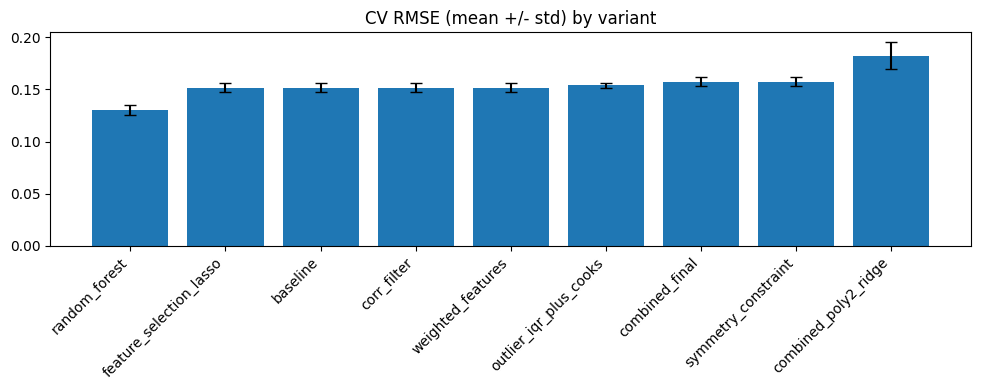

In [19]:
plt.figure(figsize=(10,4))
plt.bar(results_df["variant"], results_df["cv_rmse_mean"], yerr=results_df["cv_rmse_std"], capsize=4)
plt.xticks(rotation=45, ha="right")
plt.title("CV RMSE (mean +/- std) by variant")
plt.tight_layout()
plt.show()


### Statistical significance test

In [20]:
# Get R squared scores from each fold for both models
baseline_model_name = 'feature_selection_lasso'  # Original best model
improved_model_name = results_df.iloc[0]['variant']  # New best model

print(f"\nComparing: {baseline_model_name} and {improved_model_name}")

def get_fold_scores(model, X, y, cv):
    r2_scores = []
    for tr_idx, va_idx in cv.split(X):
        X_tr, y_tr = X.iloc[tr_idx].copy(), y.iloc[tr_idx].copy()
        X_va, y_va = X.iloc[va_idx].copy(), y.iloc[va_idx].copy()
        
        model.fit(X_tr, y_tr)
        pred = model.predict(X_va)
        r2 = r2_score(y_va, pred)
        r2_scores.append(r2)
    
    return np.array(r2_scores)

baseline_scores = get_fold_scores(VARIANTS[baseline_model_name], X_train, y_train_full, cv)
improved_scores = get_fold_scores(VARIANTS[improved_model_name], X_train, y_train_full, cv)

print(f"\n{baseline_model_name} R square scores per fold:")
print(f"  Mean: {baseline_scores.mean():.4f} +/- {baseline_scores.std():.4f}")

print(f"\n{improved_model_name} R square scores per fold:")
print(f"  Mean: {improved_scores.mean():.4f} +/- {improved_scores.std():.4f}")

# Paired t-test (since same folds used for both models)
differences = improved_scores - baseline_scores
print(f"\nDifferences per fold:")
print(f"Mean difference: {differences.mean():.4f}")
print(f"Std of differences: {differences.std():.4f}")

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(improved_scores, baseline_scores)

print("\nPAIRED T-TEST RESULTS")
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {len(improved_scores) - 1}")

alpha = 0.05
print(f"\nSignificance level: {alpha}")

if p_value < alpha:
    print(f"\nRESULT: Statistically SIGNIFICANT (p < {alpha})")
    print(f"{improved_model_name} is reliably better than {baseline_model_name}")
else:
    print(f"\nRESULT: NOT statistically significant (p ≥ {alpha})")

# Confidence interval for mean difference
from scipy.stats import t as t_dist
confidence_level = 0.95
dof = len(differences) - 1
t_critical = t_dist.ppf((1 + confidence_level) / 2, dof)
margin_error = t_critical * (differences.std() / np.sqrt(len(differences)))
ci_lower = differences.mean() - margin_error
ci_upper = differences.mean() + margin_error

print(f"\n{int(confidence_level*100)}% Confidence Interval for R square improvement:")
print(f"  [{ci_lower:.4f}, {ci_upper:.4f}]")

if ci_lower > 0:
    print(f"We can be {int(confidence_level*100)}% confident the improvement is positive")
else:
    print(f"Confidence interval includes zero (uncertain if truly better)")


Comparing: feature_selection_lasso and random_forest

feature_selection_lasso R square scores per fold:
  Mean: 0.5404 +/- 0.0380

random_forest R square scores per fold:
  Mean: 0.6589 +/- 0.0357

Differences per fold:
Mean difference: 0.1185
Std of differences: 0.0201

PAIRED T-TEST RESULTS
t-statistic: 11.7611
p-value: 0.000299
Degrees of freedom: 4

Significance level: 0.05

RESULT: Statistically SIGNIFICANT (p < 0.05)
random_forest is reliably better than feature_selection_lasso

95% Confidence Interval for R square improvement:
  [0.0935, 0.1435]
We can be 95% confident the improvement is positive


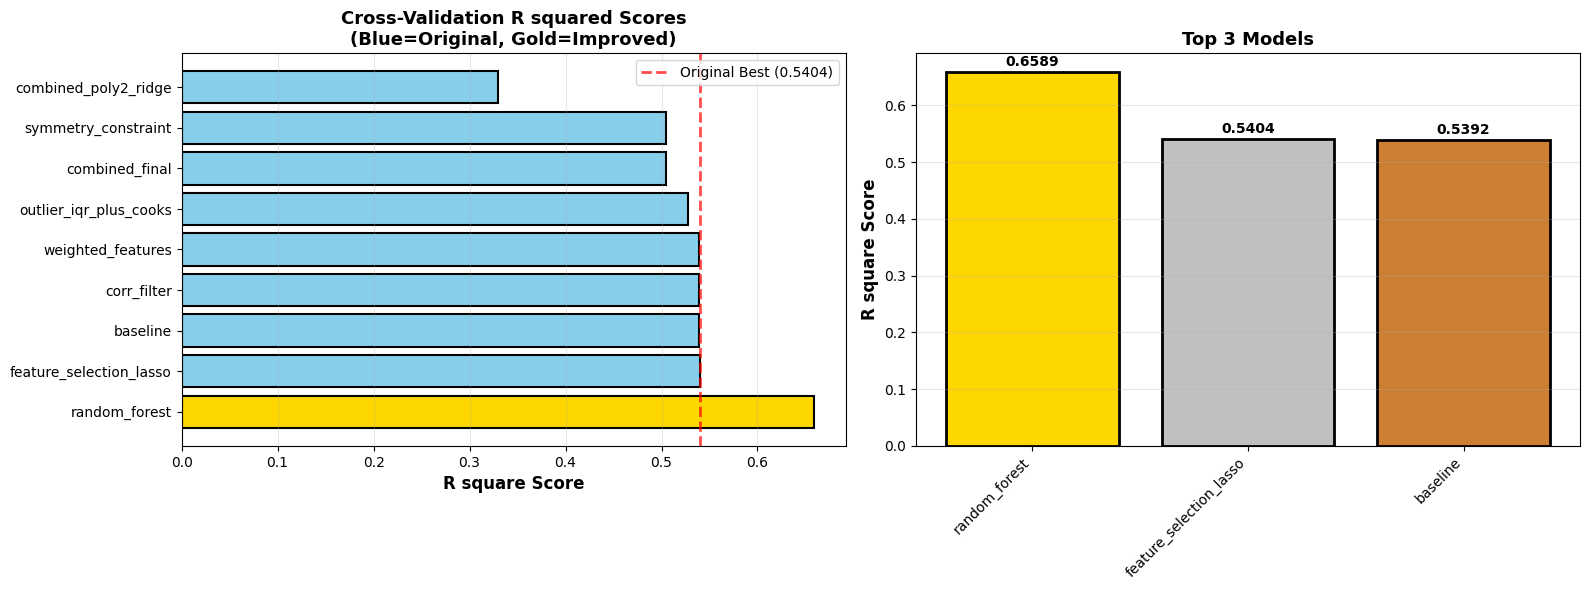



IMPROVEMENT SUMMARY
Original Best Model: feature_selection_lasso
Original CV R square: 0.5404

New Best Model: random_forest
New CV R square: 0.6589


In [21]:
# Comparison of old models vs improved models

# Separate models
original_models = ['baseline', 'corr_filter', 'feature_selection_lasso', 
                  'combined_poly2_ridge', 'symmetry_constraint', 
                  'weighted_features', 'combined_final', 'outlier_iqr_plus_cooks']

improved_models = ['random_forest']

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: R square comparison
all_variants = results_df['variant']
all_r2 = results_df['cv_r2_mean']
colors = ['skyblue' if v in original_models else 'gold' for v in all_variants]

axes[0].barh(all_variants, all_r2, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('R square Score', fontweight='bold', fontsize=12)
axes[0].set_title('Cross-Validation R squared Scores\n(Blue=Original, Gold=Improved)', 
                  fontweight='bold', fontsize=13)
axes[0].axvline(0.5404, color='red', linestyle='--', linewidth=2, 
               label='Original Best (0.5404)', alpha=0.7)
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Top 3 models
top_3 = results_df.head(3)
axes[1].bar(range(len(top_3)), top_3['cv_r2_mean'], 
           color=['gold', 'silver', '#CD7F32'], edgecolor='black', linewidth=2)
axes[1].set_xticks(range(len(top_3)))
axes[1].set_xticklabels(top_3['variant'], rotation=45, ha='right')
axes[1].set_ylabel('R square Score', fontweight='bold', fontsize=12)
axes[1].set_title('Top 3 Models', fontweight='bold', fontsize=13)
axes[1].grid(axis='y', alpha=0.3)

# Add values on bars
for i, r2 in enumerate(top_3['cv_r2_mean']):
    axes[1].text(i, r2 + 0.01, f'{r2:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print improvement
baseline_r2 = 0.5404
best_r2 = results_df.iloc[0]['cv_r2_mean']
improvement = ((best_r2 - baseline_r2) / baseline_r2) * 100

print("\n")
print("IMPROVEMENT SUMMARY")
print(f"Original Best Model: feature_selection_lasso")
print(f"Original CV R square: {baseline_r2:.4f}")
print(f"\nNew Best Model: {results_df.iloc[0]['variant']}")
print(f"New CV R square: {best_r2:.4f}")

# Select champion variant

In [22]:
champion_name = results_df.iloc[0]["variant"]
print(f"CHAMPION VARIANT: {champion_name}")
print(f"CV Correlation: {results_df.iloc[0]['cv_corr_mean']:.4f}")
print(f"CV RMSE: {results_df.iloc[0]['cv_rmse_mean']:.4f}")
print(f"CV MAE: {results_df.iloc[0]['cv_mae_mean']:.4f}")
print(f"CV R squared: {results_df.iloc[0]['cv_r2_mean']:.4f}")

# Get the actual estimator for champion
if champion_name == "outlier_iqr_plus_cooks":
    champion_pipe = make_baseline()
    # Clean entire training set once for final model
    X_tr2, y_tr2 = remove_outliers_iqr(X_train, y_train_full, k=1.5)
    X_tr3, y_tr3 = remove_cooks_distance(X_tr2, y_tr2, threshold=None)
    champion_pipe.fit(X_tr3, y_tr3)
else:
    champion_pipe = VARIANTS[champion_name]
    champion_pipe.fit(X_train, y_train_full)


CHAMPION VARIANT: random_forest
CV Correlation: 0.8264
CV RMSE: 0.1306
CV MAE: 0.0996
CV R squared: 0.6589


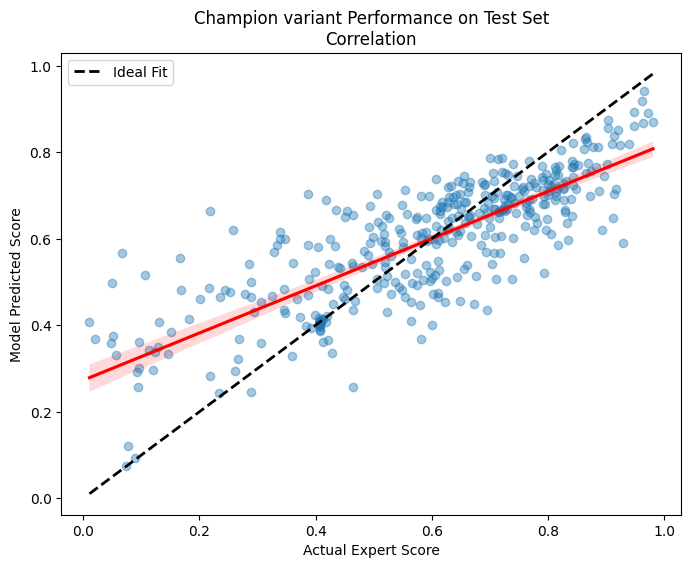

In [23]:
plt.figure(figsize=(8, 6))
y_pred = champion_pipe.predict(X_test)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.title(f'Champion variant Performance on Test Set\nCorrelation')
plt.xlabel('Actual Expert Score')
plt.ylabel('Model Predicted Score')
plt.legend()
plt.show()


# Final evaluation on testset

In [24]:
print("TEST SET EVALUATION")

test_pred = champion_pipe.predict(X_test)
test_rmse, test_mae, test_r2, test_corr = compute_metrics(y_test, test_pred)

print(f"TEST RMSE: {test_rmse:.4f}")
print(f"TEST MAE : {test_mae:.4f}")
print(f"TEST R squared  : {test_r2:.4f}")
print(f"TEST Corr: {test_corr:.4f}")

TEST SET EVALUATION
TEST RMSE: 0.1303
TEST MAE : 0.0972
TEST R squared  : 0.6356
TEST Corr: 0.8089


# Save champion variant

In [25]:
artifact = {
    "model": champion_pipe,
    "feature_columns": kept_cols,
    "target": TARGET_COL,
    "dropped": DROP_FEATURES,
    "train_metrics": {
        "cv_rmse_mean": float(results_df.iloc[0]['cv_rmse_mean']),
        "cv_r2_mean": float(results_df.iloc[0]['cv_r2_mean']),
        "cv_corr_mean": float(results_df.iloc[0]['cv_corr_mean']),
    },
    "test_metrics": {
        "rmse": float(test_rmse),
        "mae": float(test_mae),
        "r2": float(test_r2),
        "correlation": float(test_corr)
    },
    "overfitting_gap": {
        "r2_gap": float(results_df.iloc[0]['cv_r2_mean'] - test_r2),
    }
}
out_path = OUT_DIR/"aimoscores_improved.pkl"
with open(out_path, "wb") as f:
    pickle.dump(artifact, f)

print(f"Saved as Pickle: {out_path}")

Saved as Pickle: models\aimoscores_improved.pkl
